# Craigslist Car Prediction

## Manufacturing Data-Driven Price Model
by Roger Pineda

# Overview
This project uses regression modeling to predict the price of new and used vehicles based on car information listed on Craigslist. The purpose for this project is to aid any person currently deciding on whether they are in the market to purchase or sell a vehicle. This notebook focuses on a dataset retrieved from Kaggle. Prior to cleaning the dataset had around 430k car listings and had 26 columns.

Current steps to create a workable model will be:
1. Explore and scrub our data
2. Use regression models suggested by jigsawacademy.com (within modeling notebook)
3. Analyze results
4. Prediction with new data

# Business Understanding
Currently the car market has gone to a state where there is such uncertantity with supply that older cars are no longer seen as a cheap throw away. People are trying to purchase cars   

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import string
import re
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer
%matplotlib inline

In [2]:
# Functions that will be used within the notebook
def onehotencoder(column_name, df):
    column_name_ohe = df[[column_name]]
    ohe = OneHotEncoder(categories = 'auto', sparse = False)
    ohe.fit(column_name_ohe)
    column_transformed = ohe.transform(column_name_ohe)
    column_encoded_ohe = pd.DataFrame(column_transformed, columns = ohe.get_feature_names([column_name]), index = df.index)
    return column_encoded_ohe

def list_contains(List1, List2): 
    check = False
  
    # Iterate in the 1st list 
    for m in List1: 
  
        # Iterate in the 2nd list 
        for n in List2: 
    
            # if there is a match
            if m == n: 
                check = True
                return check  
                  
    return check

Loading in the data

In [3]:
df= pd.read_csv('CraigslistCars.csv')

In [4]:
# Making a copy of the main dataframe so if mistake is made don't have to relaod the entire thing,
df_1 = df.copy()


In [5]:
df_1.head()
# visually seeing the first 5 rows of the raw dataset

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


From the first few lines we are seeing that there are many rows that have NaN as a value within a column.

In [6]:
# Will take a random sample of a row to see if an arbritrary row will also follow suit of the first 5 rows by having 
# multiple NaN values
df_1.sample()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
401636,7306519713,https://bellingham.craigslist.org/ctd/d/lynnwo...,bellingham,https://bellingham.craigslist.org,54999,2016.0,rover,sport,NaN,8 cylinders,...,NaN,SUV,NaN,https://images.craigslist.org/01515_k4b2vUesvd...,⭐ FREE DELIVERY to Bellingham WAAsk us about o...,NaN,wa,47.81247,-122.32164,2021-04-13T20:14:57-0700


As you may possibly see above at least one column could have a NaN value in a row.

In [7]:
# Want to see what are the 25 columns that will be dealt with. Also will see which should be the target for this dataset
df_1.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

Seeing that within the dataset that price exists and therefore should be a solid target to predict.

In [8]:
# Seeing the range of the prices
df_1.price.min(), df_1.price.max()

(0, 3736928711)

With the range of the target being 3736928711 from the minimum to the maximum it is safe to say there may exist outliers within the dataset.

C:\Users\roger\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


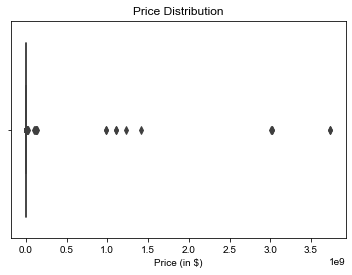

In [9]:
b =sns.boxplot( df_1['price'] ) #creating a boxplot to show the distribution of the values within the target column
b.set(xlabel = "Price (in $)", title='Price Distribution')
sns.set_style("dark");

As seen in the boxplot above the price column has values that in the billions of dollars and may or may not be proper listings.

In [10]:
# The range of price within the dataset goes from 0 to 3,736,928,711
# Want to check out the years of these vehicles because some older cars have been valued in the millions
df_1.loc[df_1['price'] == df_1.price.min(), ['year']], df_1.loc[df_1['price']==df_1.price.max(), ['year']]

(          year
 10         NaN
 11         NaN
 12         NaN
 13         NaN
 14         NaN
 ...        ...
 426764  2018.0
 426812  2006.0
 426832  2004.0
 426836  2018.0
 426868  2010.0
 
 [32895 rows x 1 columns],
           year
 318592  2007.0
 356716  1999.0)

Seeing that over 30,000 rows have the price of 0 and 2 have the large value it is showing the dataset is far fromm perfect

Best way to have the price of 0 not sway modeling later on is to limit price values as well as these strange values that are in the billions. Therefore will take an inner 90% of the data.

In [11]:
df_1['price'] = df_1['price'][df_1['price'].between(df_1['price'].quantile(.085), df_1['price'].quantile(.985),inclusive=True)]
df_1.price.min(), df_1.price.max()
# shows 100 - 59999 is an inner 90%%

(100.0, 59999.0)

Making a new df with the target column limited in range will make it so the outliers don't come into play when coming time to model.

## Making a new DF with limited price values

In [12]:
# Making new df of just values of cars between 100 and 59,999
df_2 = df_1.loc[(df_1['price']>100) & (df_1['price'] <59999)].copy()
df_2.head(), len(df_2)

(           id                                                url  \
 0  7222695916  https://prescott.craigslist.org/cto/d/prescott...   
 1  7218891961  https://fayar.craigslist.org/ctd/d/bentonville...   
 2  7221797935  https://keys.craigslist.org/cto/d/summerland-k...   
 3  7222270760  https://worcester.craigslist.org/cto/d/west-br...   
 4  7210384030  https://greensboro.craigslist.org/cto/d/trinit...   
 
                    region                         region_url    price  year  \
 0                prescott    https://prescott.craigslist.org   6000.0   NaN   
 1            fayetteville       https://fayar.craigslist.org  11900.0   NaN   
 2            florida keys        https://keys.craigslist.org  21000.0   NaN   
 3  worcester / central MA   https://worcester.craigslist.org   1500.0   NaN   
 4              greensboro  https://greensboro.craigslist.org   4900.0   NaN   
 
   manufacturer model condition cylinders  ... size  type paint_color  \
 0          NaN   NaN       N

# Dealing with all the possible NaN values in the dataset

In [13]:
df_2.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1018
manufacturer     15164
model             4321
condition       145292
cylinders       155429
fuel              2564
odometer          2221
title_status      7543
transmission      1775
VIN             148750
drive           117540
size            276055
type             82942
paint_color     113668
image_url           62
description         64
county          383903
state                0
lat               3461
long              3461
posting_date        62
dtype: int64

year, manufacturer, model, condition, cylinders, fuel, odometer, title_status, transmission, VIN, drive, size, type, paint_color
image_url, description, county, state, lat, long, posting_date have Na values and some have around 40% of its rows with NaN values.

In [14]:
# Checking the 'county' column since it has the most NaN values.
df_2['county'].value_counts()
# is completely empty

Series([], Name: county, dtype: int64)

In [15]:
# The column is not going to be useful therefore it is safe to just drop it
df_2.drop('county', axis=1, inplace=True)
df_2.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


County dealt with

The 'year' column is the first column that shows it has NaN values so lets take a deeper dive into the column

In [16]:
df_2['year'].value_counts()

2018.0    31248
2017.0    31229
2013.0    27950
2015.0    27462
2016.0    26741
          ...  
1915.0        1
1913.0        1
1909.0        1
1905.0        1
1918.0        1
Name: year, Length: 112, dtype: int64

In [17]:
# Checking the oldest car
df_2['year'].min()

1900.0

In [18]:
# Checking newest car
df_2.year.max()

2022.0

In [19]:
# Making a sorted list of all the years of the cars represented in the dataset
unique_years = df_2['year'].unique()
print(sorted(unique_years))

[nan, 1900.0, 1901.0, 1905.0, 1909.0, 1910.0, 1913.0, 1915.0, 1916.0, 1918.0, 1920.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1943.0, 1944.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0]


Barring a couple of years in the early 1900's, the dataset seems to have nearly every year in the 20th century and all years that have occured in the 21st century.

In [20]:
df_2.year.value_counts(normalize=True)
# most of the cars stated year is within the past 6 years

2018.0    0.081612
2017.0    0.081562
2013.0    0.072998
2015.0    0.071724
2016.0    0.069841
            ...   
1915.0    0.000003
1913.0    0.000003
1909.0    0.000003
1905.0    0.000003
1918.0    0.000003
Name: year, Length: 112, dtype: float64

From the method above we somewhat see that most of the years of the cars listed in the dataset are from the past 6 years.

C:\Users\roger\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


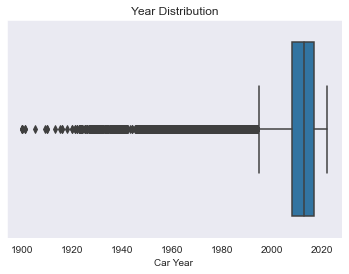

In [21]:
# Creating a visual to see the distribution of the years in the dataset.
p=sns.boxplot(df_2.year) #grabbing the years from the dataframe
p.set(xlabel = 'Car Year ', title='Year Distribution') #Seeting labels
sns.set_style("dark");

From the boxplot above we are seeing most of the interquartile data falls in after the year 2000 and the mean falls a bit before the 2020.

Want to remove some of the lower outliers that exist in the year column so will first look for the top 90% of the years in the dataset.

In [22]:
df_top_years = df_2.copy()
df_top_years['year'] = df_top_years['year'][df_top_years['year'].between(df_top_years['year'].quantile(.1), df_top_years['year'].quantile(1),inclusive=True)]
df_top_years.year.min(), df_top_years.year.max()

(2003.0, 2022.0)

We come to see that the lower end of starting years for cars that we should be looking at is after the year 2002. Anything prior could mess up the data.

## Making new Dataframe with limited amount of years. 

In [23]:
# grabbing only values with years greater than 2002
df_limited_years= df_2.loc[df_2['year'] >2002].copy()

In [24]:
# Seeing the amount of NaN values within the remaining dataset.
df_limited_years.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer     10234
model             2530
condition       133836
cylinders       144503
fuel              2226
odometer          2050
title_status      7004
transmission      1645
VIN             120074
drive           105630
size            253876
type             69704
paint_color     101144
image_url            0
description          2
state                0
lat               3283
long              3283
posting_date         0
dtype: int64

Now that two key columns have been dealt with it is time to start looking at the rest of the dataset and to find ways for the empty values to be filled in.

## Attempts on filling NaN values using the model column

In [25]:
# A new df is being made with all the rows where the condition column does not have an NaN value.
df_condition = df_limited_years.loc[df_limited_years['condition'].notna()].copy()
# Taking the df above and focusing on where the 'model' column also doesn't have any NaN values.
df_model_and_condition = df_condition.loc[df_condition['model'].notna()].copy()
# Making an empty dictionary
condition_dict = {}
# This for loop will grab all the associated values of model and condition of the vehicle and save it within the dictionary 
# above
for a, b in df_model_and_condition[['model', 'condition']].values:
    condition_dict[a] = b
# Here with the dictionary above it will run through the 'condition' column and fill out missing values with appropiate ones
# found within the made dictionary above
df_limited_years['condition'] = df_limited_years.apply(lambda x: x['condition'] if pd.isna(x['model']) or pd.notna(x['condition']) else condition_dict[x['model']] if x['model'] in condition_dict.keys() else x['condition'], axis=1)

In [26]:
# We see that it filled in 116,072 NaN values within the 'condition' column
df_limited_years.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer     10234
model             2530
condition        17764
cylinders       144503
fuel              2226
odometer          2050
title_status      7004
transmission      1645
VIN             120074
drive           105630
size            253876
type             69704
paint_color     101144
image_url            0
description          2
state                0
lat               3283
long              3283
posting_date         0
dtype: int64

In [27]:
# Will do same procedure as abpve with the 'cylinders' column
df_cylinders = df_limited_years.loc[df_limited_years['cylinders'].notna()].copy()

df_cylinders_model = df_cylinders.loc[df_cylinders['model'].notna()].copy()

cylinders_dictionary = {}

for c, d in df_cylinders_model[['model', 'cylinders']].values:
    cylinders_dictionary[c] = d
df_limited_years['cylinders'] = df_limited_years.apply( lambda x: x['cylinders'] if pd.isna( x['model'] ) or pd.notna( x['cylinders'] ) else cylinders_dictionary[x['model']] if x['model'] in cylinders_dictionary.keys() else x['cylinders'], axis=1)

In [28]:
df_limited_years.isna().sum()
# 109,649 NaN values filled in

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer     10234
model             2530
condition        17764
cylinders        34854
fuel              2226
odometer          2050
title_status      7004
transmission      1645
VIN             120074
drive           105630
size            253876
type             69704
paint_color     101144
image_url            0
description          2
state                0
lat               3283
long              3283
posting_date         0
dtype: int64

In [29]:
# Same procedure as down above
df_manufacturer = df_limited_years.loc[df_limited_years['manufacturer'].notna()].copy()
df_manufacturer_model = df_manufacturer.loc[df_manufacturer['model'].notna()].copy()
manufacturer_dictionary = {}
for e, f in df_manufacturer_model[['model', 'manufacturer']].values:
    manufacturer_dictionary[e] = f
df_limited_years['manufacturer'] = df_limited_years.apply( lambda x: x['manufacturer'] if pd.isna( x['model'] ) or pd.notna( x['manufacturer'] ) else manufacturer_dictionary[x['model']] if x['model'] in manufacturer_dictionary.keys() else x['manufacturer'], axis=1)

In [30]:
df_limited_years.isna().sum()
# 445 NaN values filled in

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer      9789
model             2530
condition        17764
cylinders        34854
fuel              2226
odometer          2050
title_status      7004
transmission      1645
VIN             120074
drive           105630
size            253876
type             69704
paint_color     101144
image_url            0
description          2
state                0
lat               3283
long              3283
posting_date         0
dtype: int64

## Using the groupby function to also fill in NaN values using the model column

In [31]:
# A groupy forward fill can be applied here to use the model column to appropiately fill in other columns with missing values
df_limited_years['cylinders'] = df_limited_years.groupby('model')['cylinders'].ffill()
df_limited_years['manufacturer'] = df_limited_years.groupby('model')['manufacturer'].ffill()
df_limited_years['fuel']=df_limited_years.groupby('model')['fuel'].ffill()
df_limited_years['odometer'] = df_limited_years['odometer'].fillna(df_limited_years.groupby(['year','model'])['odometer'].transform('mean'))
df_limited_years['size']= df_limited_years.groupby('model')['size'].ffill()
df_limited_years['type']= df_limited_years.groupby('model')['type'].ffill()
df_limited_years['manufacturer']= df_limited_years.groupby('model')['manufacturer'].ffill()

In [32]:
df_limited_years.isna().sum()
# cylinders filled in 1,410 NaN values
# condition filled in none
# fuel filled in 816 NaN values
# odometer with transforming and using the mean filled in 1658
# size filled in 162,271 NaN values
# type filled in 59,738 NaN values
# manufacturer filled in none 

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer      9789
model             2530
condition        17764
cylinders        33444
fuel              1410
odometer           392
title_status      7004
transmission      1645
VIN             120074
drive           105630
size             91605
type              9966
paint_color     101144
image_url            0
description          2
state                0
lat               3283
long              3283
posting_date         0
dtype: int64

Above shows how many columns were filled in by the groupby forward fill using the model column. Conceptually it makes sense since most individual models of cars tend to have the same features.

Manufacturer is a very important column so want to see what car makers are in the column.

In [33]:
unique_manufacturer = df_2['manufacturer'].unique() #Grabbing all the values within the manufacturer column
manufacturer_list = list(unique_manufacturer) #saving all the values into a list
manufacturer_list =manufacturer_list[1:] #doing this to exclude the NaN value that appears in the list
manufacturer_list

['gmc',
 'chevrolet',
 'toyota',
 'ford',
 'jeep',
 'nissan',
 'ram',
 'mazda',
 'cadillac',
 'honda',
 'dodge',
 'lexus',
 'jaguar',
 'buick',
 'chrysler',
 'volvo',
 'audi',
 'infiniti',
 'lincoln',
 'alfa-romeo',
 'subaru',
 'acura',
 'hyundai',
 'mercedes-benz',
 'bmw',
 'mitsubishi',
 'volkswagen',
 'porsche',
 'kia',
 'rover',
 'mini',
 'pontiac',
 'fiat',
 'tesla',
 'saturn',
 'mercury',
 'harley-davidson',
 'datsun',
 'aston-martin',
 'land rover',
 'morgan',
 'ferrari']

Seeing there are a variety of car makers from around the world exists in the dataset then it is key to find ways to fill in the column.

As seen in one of the variations of the random sample done above it was determined that when a manufacturers column was empty that the true value could have been found within the description of the vehicle. Threw domain knowledge this carries much ground.

In [34]:
# Taking in a sample of a description of a row whose manufacturer value is NaN to see if the value is is in the description 
# column.
sample = df_2['description'][97]

In [35]:
len(sample)
# Checking the length. 

4573

In [36]:
# Seeing that it is 4573 in length and it contains punction will use regexptokenizer to remove punctions and simply the 
# sample
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)
sample_doc = tokenizer.tokenize(sample)
sample_doc = [token.lower() for token in sample_doc]
sw =stopwords.words('english')
sample_doc = [token for token in sample_doc if token not in sw]

In [37]:
len(set(sample_doc))
# The length of the sample has decresed to 252 in length making it easier on the machine to run through and search.

252

In [38]:
type(sample_doc)

list

In [39]:
# Using the function list_contains to see if it true whether the sample doc has at least one of the strings in the
# manufacturer list
List1 = unique_manufacturer
List2 = sample_doc 
print("Test Case#1 ", list_contains(List1, List2)) 

Test Case#1  True


As we see above we have a true finding of having an empty manufacturer cell in the dataframe having its true value found in the description of the vehicle.

In [40]:
# Seeing which car maker is within the desciption
car = set(unique_manufacturer) & set(sample_doc)
car

{'toyota'}

With it proven that the car makers name can be found with the description of the vehicle will now use the description column to help fill out the NaN values within the manufacturer column.

In [41]:
# Making a new df where it is grabbing all the rows where the manufacturer is NaN and grabbing its associated description
# and id column
manu_desc=df_limited_years.loc[df_limited_years['manufacturer'].isna(), ['description','manufacturer', 'id']].copy()
manu_desc.head()

,description,manufacturer,id
97,Carvana is the safer way to buy a car During t...,NaN,7309271279
122,"2005 Blue Bird 12 window, 72 passenger bus tha...",NaN,7306198330
135,Carvana is the safer way to buy a car During t...,NaN,7305150004
155,Carvana is the safer way to buy a car During t...,NaN,7302642422
220,2006 STERLING ACTERRA GRAPPLE TRUCK PAC-MAC LO...,NaN,7316423933


In [42]:
# Lowercasing and making strings to all the values within the description column since the list of manufacturer are all
# lowercase
manu_desc['description']=manu_desc['description'].str.lower().str.split()

In [43]:
# checking to see if it worked
manu_desc.head()

,description,manufacturer,id
97,"[carvana, is, the, safer, way, to, buy, a, car...",NaN,7309271279
122,"[2005, blue, bird, 12, window,, 72, passenger,...",NaN,7306198330
135,"[carvana, is, the, safer, way, to, buy, a, car...",NaN,7305150004
155,"[carvana, is, the, safer, way, to, buy, a, car...",NaN,7302642422
220,"[2006, sterling, acterra, grapple, truck, pac-...",NaN,7316423933


In [44]:
# Now making for loops to run through and fill in an empty list with the common values
index_nums=[]
m =[]
for index, row in manu_desc.iterrows():   #runs through all the rows grabbing the index and the complete value
    for manufacturer in manufacturer_list: #runs through the manufacturer list 
        if manufacturer in row['description']:  #seeing if the value has a common value from the list
            index_nums.append(index)        #appending its index to index_nums empty list from above
            m.append(manufacturer)          #appending the assocaited values from the list and row 

In [45]:
# Here was just showing the result of the loop showing that it work. But it is very long and takes up a lot of space on the
# repo so it is commented out. For those cloning it down you can uncomment it and look
# result = [None]*(len(index_nums)+len(m))
# result[::2] = index_nums
# result[1::2] =m

# for x, y in zip(result[::2], result[1::2]):
    
#     print(x,y)

In [46]:
# Making a new df from the values grabbed from the for loop above to now associate the row with the new value
manu_desc_completed = pd.DataFrame(index_nums, columns=['index'])    
manu_desc_completed['manufacturer'] = m

In [47]:
manu_desc_completed.head(15)

,index,manufacturer
0,220,gmc
1,220,ford
2,601,gmc
3,696,gmc
4,696,chevrolet
5,696,ford
6,696,nissan
7,696,dodge
8,696,mini
9,787,gmc


In [48]:
manu_desc_completed_new=manu_desc_completed.drop_duplicates(subset=['index']) #just grabbing first appearance of whatever
# value came from the for loop since cars can have more than one maker
manu_desc_completed_new.manufacturer.value_counts()

gmc              869
ford             297
toyota           228
chevrolet        185
dodge            105
volvo             95
hyundai           84
honda             83
nissan            78
chrysler          65
jeep              62
subaru            49
ram               44
bmw               42
infiniti          42
mercedes-benz     41
volkswagen        41
mini              39
mazda             33
mitsubishi        30
cadillac          27
morgan            26
lexus             24
ferrari           19
audi              16
lincoln           16
pontiac           15
acura             15
kia               13
mercury            5
buick              4
fiat               4
tesla              4
saturn             4
porsche            4
jaguar             4
rover              4
Name: manufacturer, dtype: int64

In [49]:
# manu_desc_completed_new.set_index('index',inplace=True ) reseting the index to the index column made above
manu_desc_completed_new.head()

,index,manufacturer
0,220,gmc
2,601,gmc
3,696,gmc
9,787,gmc
14,794,gmc


In [50]:
df_yo= df_limited_years.copy() #making a new df

In [51]:
df_yo.update(manu_desc_completed_new)  #Using the the update method to fill in the missing values that were generated from
# operations above
df_yo.isna().sum()
# We see 2,716 NaN values were filled in.

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer      9740
model             2530
condition        17764
cylinders        33444
fuel              1410
odometer           392
title_status      7004
transmission      1645
VIN             120074
drive           105630
size             91605
type              9966
paint_color     101144
image_url            0
description          2
state                0
lat               3283
long              3283
posting_date         0
dtype: int64

Seeing that the description column could fill in NaN values for the manufacturer it probably can work for other columns as well. The same steps from the procedure above will be used on other columns that are deemed fit to have this work.

With the procedure thought process broken down from cell to cell for you the reader to follow what is going on with the example of the manufacturer column we can now just put everything into one cell for future columns. 

In [52]:
# Making a list of the condition of the vehicle
unique_condition = df_2['condition'].unique()
condition_list = list(unique_condition)
condition_list =condition_list[1:]
# condition_list

# New df with all rows of NaN values from condition
cond_desc=df_limited_years.loc[df_limited_years['condition'].isna(), ['description','condition', 'id']].copy()

cond_desc['description']=cond_desc['description'].str.lower().str.split()
# lowering the description column

# Grabbing index and value of occurance
index_nums2=[]
c =[]
for index, row in cond_desc.iterrows():
    for condition in condition_list:
        if condition in row['description']:
            index_nums2.append(index)
            c.append(condition) 

# Same as above of it being a printed out version of it working. Leaving it commented it out because list is long and would
# clog up this repository
# result2 = [None]*(len(index_nums2)+len(c))
# result2[::2] = index_nums2
# result2[1::2] =c

# for x, y in zip(result2[::2], result2[1::2]):
    
#     print(x,y)            
            
            
# Same procedure of creating a dataframe for the values found within the for loop above
cond_desc_completed = pd.DataFrame(index_nums2, columns=['index'])
cond_desc_completed['condition'] = c
cond_desc_completed_new=cond_desc_completed.drop_duplicates(subset=['index'])
cond_desc_completed_new.set_index('index',inplace=True )
cond_desc_completed_new.head()

df_yo.update(cond_desc_completed_new) #Updating the dataframe
df_yo.isna().sum() 

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer      9740
model             2530
condition         9894
cylinders        33444
fuel              1410
odometer           392
title_status      7004
transmission      1645
VIN             120074
drive           105630
size             91605
type              9966
paint_color     101144
image_url            0
description          2
state                0
lat               3283
long              3283
posting_date         0
dtype: int64

Below is a comment out attempt to use the description column to fill the cylinders column. This will not work because any number that is found in the description column could be considered as a value for the cylinders. So any phone number or street address could have been applied to the creation of the dataframe that would have been used to update the df_yo

In [53]:
# unique_cylinders = df_2['cylinders'].unique()
# cylinders_list = list(unique_cylinders)
# cylinders_list = cylinders_list[1:]

# cyld_desc=df_limited_years.loc[df_limited_years['cylinders'].isna(), ['description','cylinders', 'id']].copy()
# cyld_desc['description']=cyld_desc['description'].str.lower().str.split()

# ll=[]
# cy =[]
# for index, row in cyld_desc.iterrows():
#     for cylinders in cylinders_list:
#         if cylinders in row['description']:
#             ll.append(index)
#             cy.append(manufacturer)  
# result3 = [None]*(len(ll)+len(cy))
# result3[::2] = ll
# result3[1::2] =cy
# result3
# # for x, y in zip(result3[::2], result3[1::2]):
    
# #     print(x,y)

In [54]:
#Same procedure above with grabbing the values in the fuel column and making a list
unique_fuel = df_limited_years['fuel'].unique()
fuel_list = list(unique_fuel)
fuel_list = ['gas', 'diesel', 'hybrid', 'electric']

# Same procedure as above where grabbing the rows and columns where the fuel column is empty
fuel_desc=df_limited_years.loc[df_limited_years['fuel'].isna(), ['description','fuel', 'id']].copy()
fuel_desc['description']=fuel_desc['description'].str.lower().str.split()


# Same procedure as above with running a for loop to grab the value and occurance in the dataframe
index_nums4=[]
f =[]
for index, row in fuel_desc.iterrows():
    for fuel in fuel_list:
        if fuel in row['description']:
            index_nums4.append(index)
            f.append(fuel)

# Same as above of it being a printed out version of it working. Leaving it commented it out because list is long and would
# clog up this repository
# result4 = [None]*(len(index_nums4)+len(f))
# result4[::2] = index_nums4
# result4[1::2] =f

# for x, y in zip(result4[::2], result4[1::2]):
    
#     print(x,y)

# Same procedure as before with making a new dataframe of the index and their associated value.
fuel_desc_completed = pd.DataFrame(index_nums4, columns=['index'])
fuel_desc_completed['fuel'] = f
fuel_desc_completed_new=fuel_desc_completed.drop_duplicates(subset=['index'])
fuel_desc_completed_new.set_index('index',inplace=True )
fuel_desc_completed_new.head()


df_yo.update(fuel_desc_completed_new) #Updating the dataframe with new found values
df_yo.isna().sum() #checking how many NaN that were filled

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer      9740
model             2530
condition         9894
cylinders        33444
fuel              1215
odometer           392
title_status      7004
transmission      1645
VIN             120074
drive           105630
size             91605
type              9966
paint_color     101144
image_url            0
description          2
state                0
lat               3283
long              3283
posting_date         0
dtype: int64

In [55]:
#Same procedure as before with grabbing the values of the transmission column and saving them into a list
unique_transmission = df_limited_years['transmission'].unique()
trasnmission_list = list(unique_transmission)
transmission_list = ['automatic', 'manual']

# Same procdure as before where grabbing the rows and columns where transmission is Nan
tran_desc=df_limited_years.loc[df_limited_years['transmission'].isna(), ['description','transmission', 'id']].copy()
tran_desc['description']=tran_desc['description'].str.lower().str.split()

# Same procedure as above with running a for loop to grab the value and occurance in the dataframe
index_nums5=[]
t =[]
for index, row in tran_desc.iterrows():
    for transmission in transmission_list:
        if transmission in row['description']:
            index_nums5.append(index)
            t.append(transmission)  

# Same as above of it being a printed out version of it working. Leaving it commented it out because list is long and would
# clog up this repository
# result5 = [None]*(len(index_nums5)+len(t))
# result5[::2] = index_nums5
# result5[1::2] =t

# for x, y in zip(result5[::2], result5[1::2]):
    
#     print(x,y)
            
            
# Same procedure as before with making a new dataframe of the index and their associated value.
tran_desc_completed = pd.DataFrame(index_nums5, columns=['index'])
tran_desc_completed['transmission'] = t
tran_desc_completed_new=tran_desc_completed.drop_duplicates(subset=['index'])
tran_desc_completed_new.set_index('index',inplace=True )
tran_desc_completed_new.head()

df_yo.update(tran_desc_completed_new) #updating the dataframe
df_yo.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer      9740
model             2530
condition         9894
cylinders        33444
fuel              1215
odometer           392
title_status      7004
transmission      1158
VIN             120074
drive           105630
size             91605
type              9966
paint_color     101144
image_url            0
description          2
state                0
lat               3283
long              3283
posting_date         0
dtype: int64

In [56]:
# grabbing the unique values of the drive column and asving them into a list
unique_drive = df_limited_years['drive'].unique()
drive_list = list(unique_drive)
drive_list= drive_list[1:]
# drive_list

#Same procedure as above where grabbing only rows were drive column is NAN
driv_desc=df_limited_years.loc[df_limited_years['drive'].isna(), ['description','drive', 'id']].copy()
driv_desc['description']=driv_desc['description'].str.lower().str.split()

# driv_desc.isna().sum()
# # Seeing if any NaN values exist within the description column because it will interfere with the for loop
# # There is and that row will be dropped

driv_desc.dropna(subset=['description'], axis=0, inplace=True)
# dropping the row

# Same procedure as above with running a for loop to grab the value and occurance in the dataframe
index_nums6=[]
d =[]
for index, row in driv_desc.iterrows():
    for drive in drive_list:
        if drive in row['description']:
            index_nums6.append(index)
            d.append(drive)  
            
# Same as above of it being a printed out version of it working. Leaving it commented it out because list is long and would
# clog up this repository
# result6 = [None]*(len(index_nums6)+len(d))
# result6[::2] = index_nums6
# result6[1::2] =d

# for x, y in zip(result6[::2], result6[1::2]):
    
#     print(x,y)

# Same as procedure above where making a dataframe from the results of the for loop
driv_desc_completed = pd.DataFrame(index_nums6, columns=['index'])
driv_desc_completed['drive'] = d
driv_desc_completed_new=driv_desc_completed.drop_duplicates(subset=['index'])
driv_desc_completed_new.set_index('index',inplace=True )
# driv_desc_completed_new.head()

df_yo.update(driv_desc_completed_new) #updating the dataframe with dataframe made above
df_yo.isna().sum() #Chechking NAN values it filled in

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer      9740
model             2530
condition         9894
cylinders        33444
fuel              1215
odometer           392
title_status      7004
transmission      1158
VIN             120074
drive            93792
size             91605
type              9966
paint_color     101144
image_url            0
description          2
state                0
lat               3283
long              3283
posting_date         0
dtype: int64

In [57]:
# Grabbing the unique values from the size column and saving into a list
unique_size = df_limited_years['size'].unique()
size_list = list(unique_size)
size_list= size_list[1:]
# size_list

# Same procedure as before with just grabbing the rows where size is NaN
size_desc=df_limited_years.loc[df_limited_years['size'].isna(), ['description','size', 'id']].copy()
size_desc['description']=size_desc['description'].str.lower().str.split()

# Same procedure as above with running a for loop to grab the value and occurance in the dataframe
index_nums7=[]
s =[]
for index, row in size_desc.iterrows():
    for size in size_list:
        if size in row['description']:
            index_nums7.append(index)
            s.append(size) 

            # Same as above of it being a printed out version of it working. Leaving it commented it out because list is long and would
# clog up this repository
# result7 = [None]*(len(index_nums7)+len(s))
# result7[::2] = index_nums7
# result7[1::2] =s

# for x, y in zip(result7[::2], result7[1::2]):
    
#     print(x,y)

# Same as procedure above where making a dataframe from the results of the for loop
size_desc_completed = pd.DataFrame(index_nums7, columns=['index'])
size_desc_completed['size'] = s
size_desc_completed_new=size_desc_completed.drop_duplicates(subset=['index'])
size_desc_completed_new.set_index('index',inplace=True )

df_yo.update(size_desc_completed_new) # updating the dataframe with the values found in the dataframe above
df_yo.isna().sum() #Checking how many NaN's are filled in

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer      9740
model             2530
condition         9894
cylinders        33444
fuel              1215
odometer           392
title_status      7004
transmission      1158
VIN             120074
drive            93792
size             88753
type              9966
paint_color     101144
image_url            0
description          2
state                0
lat               3283
long              3283
posting_date         0
dtype: int64

In [58]:
#Grabbing the unique values from the type column and saving it into a list
unique_type = df_limited_years['type'].unique()
type_list = list(unique_type)
type_list = ['pickup',
 'truck',
 'other',
 'coupe',
 'SUV',
 'hatchback',
 'mini-van',
 'sedan',
 'offroad',
 'bus',
 'convertible',
 'wagon',
 'van']

#Grabbing the rows where type is NAN
type_desc=df_limited_years.loc[df_limited_years['type'].isna(), ['description','type', 'id']].copy()
type_desc['description']=type_desc['description'].str.lower().str.split()

# Same procedure as above with running a for loop to grab the value and occurance in the dataframe
index_nums8=[]
ty =[]
for index, row in type_desc.iterrows():
    for types in type_list:
        if types in row['description']:
            index_nums8.append(index)
            ty.append(types)  
            
# Same as above of it being a printed out version of it working. Leaving it commented it out because list is long and would
# clog up this repository
# result8 = [None]*(len(index_nums8)+len(ty))
# result8[::2] = index_nums8
# result8[1::2] =ty

# for x, y in zip(result8[::2], result8[1::2]):
    
#     print(x,y)

type_desc_completed = pd.DataFrame(index_nums8, columns=['index'])
type_desc_completed['type'] = ty
type_desc_completed_new=type_desc_completed.drop_duplicates(subset=['index'])
type_desc_completed_new.set_index('index',inplace=True )

df_yo.update(type_desc_completed_new)
df_yo.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year                 0
manufacturer      9740
model             2530
condition         9894
cylinders        33444
fuel              1215
odometer           392
title_status      7004
transmission      1158
VIN             120074
drive            93792
size             88753
type              4586
paint_color     101144
image_url            0
description          2
state                0
lat               3283
long              3283
posting_date         0
dtype: int64

After filling in as many NaN values as the dataset allowed we can now begin with finalizing the dataset as to prepare it for modeling.

Some columns are currently not very useful for the models and due to lack of machine power that the local machine that was used to make this repo it also can't handle their vast amount of unique values. Therefore they will be dropped from the dataset.

In [59]:
# Dropping the columns that won't be used in the dataset
df_yo.drop(['id', 'url', 'region_url', 'VIN', 'image_url', 'description', 'lat', 'long', 'posting_date'], axis=1, inplace=True)
df_yo.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
27,auburn,33590.0,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,NaN,NaN,pickup,white,al
28,auburn,22590.0,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,NaN,pickup,blue,al
29,auburn,39590.0,2020.0,gmc,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,NaN,pickup,red,al
30,auburn,30990.0,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,NaN,NaN,pickup,red,al
31,auburn,15000.0,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al


In [60]:
# Making a new df just incase a mistake is made and can be referenced back to.

df_yo1 = df_yo.copy()
df_yo1.dropna(inplace=True) #Dropping all the rows that contain NaN values within the dataset
df_yo1 = df_yo1.loc[df_yo1['odometer'] < 500000] #limiting the amount of cars with odometers less than 500,000
df_yo1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150864 entries, 31 to 426872
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        150864 non-null  object 
 1   price         150864 non-null  float64
 2   year          150864 non-null  float64
 3   manufacturer  150864 non-null  object 
 4   model         150864 non-null  object 
 5   condition     150864 non-null  object 
 6   cylinders     150864 non-null  object 
 7   fuel          150864 non-null  object 
 8   odometer      150864 non-null  float64
 9   title_status  150864 non-null  object 
 10  transmission  150864 non-null  object 
 11  drive         150864 non-null  object 
 12  size          150864 non-null  object 
 13  type          150864 non-null  object 
 14  paint_color   150864 non-null  object 
 15  state         150864 non-null  object 
dtypes: float64(3), object(13)
memory usage: 19.6+ MB


The curent dataset dropped to 150864 carlistings after heavily cleaning the data. This should be enough to for the predictive models. Currently around 280 thousand less car listings than that of the original dataset but it just shows how tainted the dataset was.

The dataset below is one that removes the columns with high remaining NAN values that I was un able to fill in. With removing them I get a dataset with far more amount of rows. over 140 thousnad rows. But due to limited computing power the local machine used to create this repo can not handle when the models were tried to be fitted onto this data. Will keep here incase anyone who wants to clone the repo wants more clean data to use.

In [61]:
df_yo2=df_yo.copy()

In [62]:
df_yo2.drop(['drive', 'size', 'paint_color'], axis=1,inplace=True)
df_yo2.dropna(inplace=True)
df_yo2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290827 entries, 27 to 426878
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        290827 non-null  object 
 1   price         290827 non-null  float64
 2   year          290827 non-null  float64
 3   manufacturer  290827 non-null  object 
 4   model         290827 non-null  object 
 5   condition     290827 non-null  object 
 6   cylinders     290827 non-null  object 
 7   fuel          290827 non-null  object 
 8   odometer      290827 non-null  float64
 9   title_status  290827 non-null  object 
 10  transmission  290827 non-null  object 
 11  type          290827 non-null  object 
 12  state         290827 non-null  object 
dtypes: float64(3), object(10)
memory usage: 31.1+ MB


In [63]:
df_yo2.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,type,state
27,auburn,33590.0,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,pickup,al
28,auburn,22590.0,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,pickup,al
29,auburn,39590.0,2020.0,gmc,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,pickup,al
30,auburn,30990.0,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,pickup,al
31,auburn,15000.0,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,truck,al


## One Hot Encoding Categorical Variables

To make the dataset fully ready for modeling the categorical variables have to be one hot encoded to as to make dummy columns where the value within the column is 1 or 0. 1 being that row has that column as a value and 0 saying that row doesn't have a column for a value.

In [64]:
# Applying the onehotencoder function that is stated at the top of the notebook to one hot encode the categoricals and
# save them into variables


# a = onehotencoder('region' , df_yo1)   curently commented out because too many columns are created from it
b = onehotencoder('manufacturer' , df_yo1)
# c = onehotencoder('model' , df_yo1)    too messy of a column therefore will be left out
d = onehotencoder('condition' , df_yo1)
e = onehotencoder('cylinders' , df_yo1)
f = onehotencoder('fuel' , df_yo1)
g = onehotencoder('title_status' , df_yo1)
h = onehotencoder('transmission' , df_yo1)
i = onehotencoder('drive' , df_yo1)
j = onehotencoder('size' , df_yo1)
k = onehotencoder('type', df_yo1)
l = onehotencoder('paint_color' , df_yo1)
m = onehotencoder('state', df_yo1)

In [65]:
# e3 =(2022-df_yo1['year'].mean())/df_yo1['year'].std()
# e3,df_yo1['year'].mean(),df_yo1['year'].std()

In [66]:
# df_yo1['odometer'].mean(), df_yo1['odometer'].std(), df_yo1['odometer'].max()

## Making final df for modeling

In [67]:
# concating all the variables that contain all the one hot encoded column names
df_final1 = pd.concat([df_yo1,b,d,e,f,g,h,i,j,k,l,m], axis=1)
df_final1.drop(['drive','region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'size', 'type', 'state', 'paint_color'], axis=1, inplace=True)
# Dropping the original categorical columns

With the remaining columns, the integer/float columns, it is best practice to scale them as for their values to not sway the data. Also best practice to log price.

In [68]:
# Scaling the year column
col_ss = ['year']  #saving the year column into col_ss
ss = StandardScaler()  #instantiating standard scaler and saving it into ss
Scaled = ss.fit_transform(df_final1[col_ss])    #fitting and transforming with standard scaler the year column and saving it within the Scaled variable 
Scaled = pd.DataFrame(Scaled, index=df_final1.index) # Taking the scaled version of the year column and turning it into a dataframe
Scaled.columns = col_ss  #making the column name of the Scaled dataframe to year
df_final1['year'] = Scaled['year']    # making the scaled versions of the year into the values within df_final1

#Scaling odometer column
col_sss = ['odometer'] #saving the ododmeter column into col_sss
Scaledd = ss.fit_transform(df_final1[col_sss]) #fitting and transforming with standard scaler the year column and saving it within the Scaled variable 
Scaledd = pd.DataFrame(Scaledd, index=df_final1.index) # Taking the scaled version of the odometer column and turning it into a dataframe
Scaledd.columns = col_sss  #making the column name of the Scaled dataframe to odometer
df_final1['odometer'] = Scaledd['odometer'] # making the scaled version of the odometer into the values within df_final1

df_final1['price'] = np.log(df_final1['price']) #using the loging method to log price and save it in the df_final1


Modeling will be done within the modeling notebook therefore have to save the final df into a pickle file to be able to bring up in other notebooks

In [69]:
# Saving the df into a pickle file
with open('cars.pkl', 'wb') as carpickle:
    pickle.dump(df_final1,carpickle)

# Predicting New Data

As to see the model in practice new data in the form of one singular vehicle will be predicted using the model.

In [81]:
# load in model
model_prediction =pickle.load(open('car_price_predictor_model.sav', 'rb'))
#Creating a new df where it it without the target and model column
X_test = df_final1.drop(['price','model'], axis=1)

# Scaling down the inputs for the year and odometer the  value minus the mean all divided by the standard deviation of the
# column
year_audi = (2020-2012.4205045603987)/4.4768709628937495
odometer_audi = (15000-102836.53701866485)/57728.5872305997

# Making a prediction only using a couple of features of the car. Them being its manufacturer, year and odometer number
#creating a dictionary with the column names and their values
inputs = {'year':year_audi,"odometer":odometer_audi, "manufacturer_audi":1} 
# making an empty dataframe with columns from X_test to append the dictionary to
input_data = pd.DataFrame(columns=X_test.columns)
#appending the dictionary to the input_data dataframe
input_data = input_data.append(inputs, ignore_index=True)
#Filling in all the NaN values to dataframe with 0's as to let the model predict the value
input_data = input_data.fillna(0)
#Predicting the value
print(f'The prediction of the price of the car with limited features is {np.exp(model_prediction.predict(input_data))}')

#Making a prediction using all of the cars features
#Creating a dataframe with all associated car features
inputss = {'year':year_audi, "odometer":odometer_audi, "manufacturer_audi":1, "condition_new":1, "cylinders_4 cylinders":1, "fuel_gas":1, "title_status_clean":1, "transmission_automatic":1, "type_sedan":1, "paint_color_white":1, "state_ny":1 }
#Creating empty dataframe with columns from X_test
input_dataa = pd.DataFrame(columns=X_test.columns)
#appending the dictionary to the input_dataa dataframe
input_dataa = input_dataa.append(inputss, ignore_index=True)
# Filling all NaN values to the dataframe with 0's as to let the model predeict the value
input_dataa = input_dataa.fillna(0)

print(f'The prediction of the price of the car with all features is {np.exp(model_prediction.predict(input_dataa))}')

The prediction of the price of the car with limited features is [34665.42500574]
The prediction of the price of the car with all features is [6470.41077062]


### Observations

When the model was given limited information of the vehicle it was able to give a fairly accurate prediction of the price. But when nearly all the information of the vehicle was put into the model it vastly undervalued the vehicle. This can mean that the model doesn't perform well when too much information is given to it.

# Conclusions

After many forms and attempts and clean this heavily mucky dataset from Kaggle it is come down that what was left over wasn't enough to allow the models to trainwell enough to acheive proper predictions. As seen in the predictions section of this notebook, the model isn't predicting well to new data. When given all the features in the datset it vastly underperforms. With the model having an RSME of 3724.54 it is way to high of a number in reference to the range of the values of the prices within the dataset. The model can either predict well over the price therefore having the buyer spend way too much for a car or way too low and having the seller lose out on profits. Currently the model needs more work and it is currently not in a position to be used by the public. 